# Description

## Libraries and Device

In [1]:
import numpy as np
import pandas as pd
import numpy.random as nrd
import os 
import math

# Pytorch modules 
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim

# this for the custom Dataset 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# 
import seaborn as sns
import matplotlib.pyplot as plt

# Import tqdm for progress bar
from tqdm.auto import tqdm

# for timing functions
from timeit import default_timer as timer 


In [2]:
# Set agnostic code - better practise, and constanly check what is in and out of 
# the device

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Set Path

In [3]:
data_path = os.getcwd() + "\\data"

## Dataset

This is the exploratory Notebooks of my VAE development. As starters I will use a simulated dataset of 64 protein examples with 150 columns each. The dataset is already normalized. 

In [4]:
nrd.seed(135)
npdata = nrd.rand(128,150)

# mix max normalization row wise for axis = 1
min = np.min(npdata, axis=1, keepdims=True)
max = np.max(npdata, axis=1, keepdims=True)
min[0],max[0]

(array([0.00232166]), array([0.99725201]))

In [5]:
# Fix data by performing min-max scaling row by row
data_scaled = (npdata - min)/(max - min + 1e-8)

In [6]:
np.max(data_scaled,axis=1)

array([0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999

In [7]:
# [argument for something in iterable] 
index = [f"protein.{index}" for index in range(1,129)] 

In [8]:
data = pd.DataFrame(data_scaled, index=index)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
protein.1,0.662365,0.327031,0.194060,0.865046,0.783784,0.156011,0.520925,0.966534,0.050490,0.932670,...,0.226263,0.997205,0.164868,0.806037,0.121547,0.131372,0.680648,0.061293,0.236959,0.685693
protein.2,0.101142,0.269817,0.647042,0.943356,0.259523,0.852959,0.981858,0.807533,0.554088,0.679886,...,0.617954,0.783175,0.283193,0.342534,0.273990,0.512392,0.194034,0.510529,0.833471,0.571514
protein.3,0.897490,0.690363,0.556613,0.540949,0.941966,0.623067,0.785674,0.088407,0.225808,0.149961,...,0.429604,0.557134,0.777735,0.761663,0.646178,0.055538,0.258139,0.086450,0.830094,0.953066
protein.4,0.103698,0.668888,0.547481,0.420895,0.781282,0.907216,0.812108,0.987955,0.188830,0.997361,...,0.547459,0.079129,0.620669,0.298319,0.300912,0.538807,0.947182,0.569507,0.880394,0.521749
protein.5,0.495218,0.737433,0.524375,0.357605,0.785050,0.996079,1.000000,0.185541,0.480244,0.000000,...,0.780116,0.045283,0.900804,0.732115,0.723675,0.415304,0.117806,0.914642,0.766553,0.479398


In [9]:
# introduce rand NAs in the dataset 
row, cols = data.shape
na_per_row = int(cols*0.1)
na_per_row

15

In [10]:
nrd.seed(135)

# create a matrix with missing indices 15 per protein
na_matrix = nrd.randint(0,cols, size = (row,na_per_row))
na_matrix.shape

(128, 15)

In [11]:
# index rows by chance
for idx, col in enumerate(na_matrix):
    data.iloc[idx,col] = np.nan
    # print(f"added {len(col)} NAs to row: {data.index[idx]}")


### Summary NAs
- for the protein we need a distribution of NAs per protein
- a data completeness threshold 
- total number of proteins available in the threshold 

In [12]:
# check the NA frequency, also it inherits the index
df_summary = pd.DataFrame({
"Protein index": data.index,
"NAs_count" : data.isna().sum(axis=1),
"Data_Completenes" : round(
    (data.shape[1] - data.isna().sum(axis=1))/data.shape[1] * 100,2)}
    )

In [13]:
df_summary

,Protein index,NAs_count,Data_Completenes
protein.1,protein.1,15,90.00
protein.2,protein.2,14,90.67
protein.3,protein.3,15,90.00
protein.4,protein.4,15,90.00
protein.5,protein.5,13,91.33
...,...,...,...
protein.124,protein.124,15,90.00
protein.125,protein.125,14,90.67
protein.126,protein.126,15,90.00
protein.127,protein.127,12,92.00


## Custom Dataset Class

In [14]:
DEFAULT_DTYPE = torch.get_default_dtype()

In [15]:
class ProteinDataset(Dataset):
    """
    It passes the whole dataset matrix to memory.
    Then, a mask matrix indicating NAs is created.
    Finally all NAs are replaced with zeroes
    Returns to the DataLoader the Dataset, Mask and
    index of the examples

    """
    nan = torch.tensor(float("NaN"))
    DEFAULT_DTYPE = torch.get_default_dtype()

    def __init__(self, data: np.array, row_ids = None, fill_na: float = 0.0):
        """
        Parameters
        ---------------------------
        data : np.array object 
            The protein dataset with the MS1 signals scaled from (0,1) with/o
            missing values.
        row_ids : np.array object
            It contains the protein ID symbols, character vector from the original
            protein table
        fill_na : int, optional
            the replacement of NAs, selected 0
        """
        if not isinstance(data, (np.ndarray)):
            raise TypeError(f"Dataset should be Numpy array object of 32 bits")
        else:
            print(f"Protein Dataset is passed to memory")
        
        # load the matrix
        self.proteins = torch.FloatTensor(data)
        
        # create boolean mask
        self.mask = torch.tensor(np.isnan(data))

        # replace values if there NAs
        self.proteins = torch.where(self.proteins.isnan(), torch.FloatTensor([fill_na]),
            self.proteins)
        
        self.length_ = len(self.proteins)

        # create a target tensor in case i need it 
        self.y = torch.where(~self.mask, self.nan, self.proteins)

        # store original indices and row names from the expression matrix 
        self.indices = np.arange(self.length_)
        self.row_ids = row_ids

        # instantiate original protein symbols
        if row_ids is None:
            print(f"No Protein Symbols were identified")
        else:
            print(f"Matrix with original Protein Symbols is identified")
            self.columns = row_ids
    
    def __len__(self):
        return self.length_
    
    def get_row_names(self, idx):
        return self.row_ids[idx]

    def __getitem__(self, idx): # __getitem__ method returns ONLY tensors 
        if self.row_ids is None:
            return (self.proteins[idx], self.mask[idx],
                torch.tensor(self.indices[idx],dtype=torch.int32))
        else:
            return (self.proteins[idx], self.mask[idx],
                torch.tensor(self.indices[idx],dtype=torch.int32))

In [16]:
data_matrix = np.array(data)
rows_np = np.array(data.index)
# rows_np

In [17]:
dataset = ProteinDataset(data_matrix, row_ids=rows_np)
dataset.length_,dataset.get_row_names([3,2])

Protein Dataset is passed to memory
Matrix with original Protein Symbols is identified


(128, array(['protein.4', 'protein.3'], dtype=object))

In [18]:
dataset.__getitem__(0)

(tensor([0.6624, 0.3270, 0.1941, 0.8650, 0.7838, 0.1560, 0.5209, 0.9665, 0.0000,
         0.9327, 0.3729, 0.1260, 0.0000, 0.1726, 0.0309, 0.6211, 1.0000, 0.7295,
         0.0390, 0.7702, 0.2654, 0.1596, 0.0000, 0.0000, 0.5829, 0.5937, 0.0416,
         0.8374, 0.0000, 0.9861, 0.9390, 0.1267, 0.5256, 0.9362, 0.0425, 0.3727,
         0.9369, 0.5715, 0.8900, 0.8151, 0.8179, 0.5992, 0.3538, 0.4102, 0.5850,
         0.0472, 0.0746, 0.7381, 0.3124, 0.7068, 0.6254, 0.4917, 0.7161, 0.8768,
         0.5470, 0.0000, 0.4428, 0.3035, 0.9706, 0.4973, 0.8557, 0.5656, 0.0000,
         0.9705, 0.8441, 0.1883, 0.5925, 0.9124, 0.5066, 0.8940, 0.5929, 0.2839,
         0.0000, 0.2078, 0.6092, 0.1481, 0.9875, 0.7862, 0.7895, 0.7615, 0.6584,
         0.8455, 0.8022, 0.4783, 0.3981, 0.0000, 0.0750, 0.8420, 0.3205, 0.4487,
         0.2321, 0.6143, 0.6390, 0.5680, 0.2967, 0.9065, 0.3033, 0.7331, 0.8211,
         0.9298, 0.7638, 0.2934, 0.0255, 0.9824, 0.3087, 0.2139, 0.4453, 0.8155,
         0.0000, 0.0232, 0.0

In [19]:
dataset.mask[1].shape

torch.Size([150])

In [20]:
# data_tensor = torch.FloatTensor(data_matrix)
# data_tensor

In [21]:
torch.tensor(np.isnan(data_matrix))

tensor([[False, False, False,  ...,  True, False, False],
        [False,  True, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True, False,  True],
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False, False, False]])

In [22]:
np.array(data).shape,data.shape

((128, 150), (128, 150))

## Dataloaders

In [23]:
data_matrix = np.array(data)
dataset = ProteinDataset(data_matrix, row_ids=rows_np)
x_train = DataLoader(dataset, batch_size=32, shuffle=True)
next(iter(x_train))

Protein Dataset is passed to memory
Matrix with original Protein Symbols is identified


[tensor([[0.9922, 0.9367, 0.1831,  ..., 0.0000, 0.4671, 0.0000],
         [0.7711, 0.1120, 0.9199,  ..., 0.1072, 0.3022, 0.8543],
         [0.0000, 0.3382, 0.0000,  ..., 0.7812, 0.0348, 0.8454],
         ...,
         [0.5779, 0.4618, 0.5073,  ..., 0.2447, 0.0140, 0.3467],
         [0.0000, 0.0963, 0.6507,  ..., 0.2365, 0.4752, 0.5034],
         [0.0899, 0.7589, 0.6226,  ..., 0.3378, 0.7901, 0.9133]]),
 tensor([[False, False, False,  ...,  True, False,  True],
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]),
 tensor([102,  32,  95,   2,  82,  83,  47, 120,  28, 125,  96,  51, 122,  63,
         116,  26,  49,  67, 108,  44,  75,  43,  60,   0,  57,  65, 119,   5,
           4, 109,  76,  48], dtype=torch.int32)]

Return A list of tensors 

In [24]:
# Example tensors (batch_size=2, features=3) normally 150 
z = torch.tensor([[1.0, 0, 3.0], [0, 5.0, 6.0]])   # Original data
mu = torch.tensor([[1.5, 2.5, 3.5], [4.5, 5.5, 6.5]])   # Decoder output (reconstructed mean)
logvar = torch.tensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]])  # Decoder log variance

mask = torch.tensor([[False, True, False],  # 2nd value in 1st row is missing
                     [True, False, False]]) # 1st value in 2nd row is missing

z.shape

torch.Size([2, 3])

In [25]:
# (z - mu)**2 / torch.exp(logvar)

In [26]:
# torch.log(2. * torch.tensor(torch.pi)) + logvar

In [27]:
# log_prob = -0.5 * (torch.log(2. * torch.tensor(torch.pi)) + logvar + (z - mu)**2 / torch.exp(logvar))
# log_prob

In [28]:
# log_prob_updated = log_prob[~mask]
# log_prob_updated

In [29]:
# -torch.sum(log_prob)
# -log_prob.mean()

In [30]:
# -torch.sum(log_prob_updated,dim=0)/log_prob_updated.shape[0]

In [31]:
# -log_prob_updated.mean()

In [32]:

# def gaussian_log_prob(z, mu, logvar, mask=None):
#     """
#     Compute Gaussian log probability while ignoring missing values using mask.
    
#     :param z: sampled latent variable (batch_size, latent_dim)
#     :param mu: mean of the latent variable (batch_size, latent_dim)
#     :param logvar: log variance of the latent variable (batch_size, latent_dim)
#     :param mask: Boolean mask (True for missing, False for observed data)
#     :return: Mean log probability over non-missing values
#     """
#     log_prob = -0.5 * (torch.log(2. * torch.tensor(torch.pi)) + logvar + (z - mu)**2 / torch.exp(logvar))
    
#     if mask is not None:
#         log_prob = log_prob[~mask]  # Subset tensor to keep only non-missing values

#     return log_prob.mean()  # Compute mean over remaining values

## VAE class model

In [ ]:
PI = torch.tensor(torch.pi, device=device)
log_of_2 = torch.log(torch.tensor(2., device=device))

class VAE(nn.Module):
    def __init__(self, 
                 n_features: int,
                 latent_dim: int,
                 hidden_layer : bool = False,
                 hidden_dim: int = None,
                 sigmoid = True):
        """
        Parameters:
        ------------------
        n_features : int
            Number of input features (columns of the protein table e.g. 150).
        latent_dim : int
            Size of latent space (e.g., 20).
        hidden_layer : bool
            A boolean value indicating whether a hidden layer is added or not.
            By default is False
        hidden_dim : int
            Number of neurons in the hidden layer (e.g., 50), if there is a hidden
            layer. Default value is None 
        sigmoid : bool
            If True, applies a Sigmoid activation to the decoder output. Usefull
            when data is scaled to (0,1). Not recommended for raw measurements. 
        
        Information
        ------------------
        The VAE has maximum one hidden layer with LeakyReLu activation function
        to the encoder. The decoder is either linear or a sigmoid activation function
        is applied if scaled data is used. 
        For Regularlization I used dropout rate equal to 0.2
        I added the choice of a model without hidden layer and with a linear 
        transformation if the data  is unscaled and raw values might be used. 
        """ 
        super().__init__()

        # Load the parameters 
        self.n_features = n_features
        self.hidden_layer = hidden_layer
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.sigmoid = sigmoid

        # the encoder module
        if hidden_layer == False: # this is linear transformation 
            self.encoder = nn.Sequential(
            # one linear Layer the latent Space: z_mu and z_logvar
            nn.Linear(self.n_features, self.latent_dim * 2)
        )
        else:
            self.encoder = nn.Sequential(
            # one hidden layer
            nn.Linear(in_features=self.n_features, out_features=self.hidden_dim),
            nn.Dropout(0.2),
            nn.BatchNorm1d(self.hidden_dim),
            nn.LeakyReLU(.1),

            # Latent Space: z_mu and z_logvar 
            nn.Linear(self.hidden_dim, self.latent_dim * 2)
            )
       
        
        # decoder module
        # No hidden Layers - separate the two heads
        if hidden_layer == False:
            decoder_list =[
            # one linear Layer the latent Space: z_mu and z_logvar
            nn.Linear(latent_dim, n_features)]
                      
            if sigmoid == True:
                decoder_list.append(nn.Sigmoid())
            
            self.head_mu = nn.Sequential(*decoder_list)
            self.head_logvar = nn.Linear(latent_dim, n_features)


        # Decoder with one hidden layer 
        else:
            # Common corpus of the decoder
            self.decoder_common = nn.Sequential(
            # From latent to hidden 
            nn.Linear(self.latent_dim, self.hidden_dim),
            nn.Dropout(0.2),
            nn.BatchNorm1d(self.hidden_dim),
            nn.LeakyReLU(.1))

            # Decoder output separated in two heads: x_mu and x_logvar 
            head_mu_list = [nn.Linear(self.hidden_dim, self.n_features)]
            if sigmoid == True:
                head_mu_list.append(nn.Sigmoid())
            
            # unpack the n x_mu variables
            self.head_mu = nn.Sequential(*head_mu_list)
            
            # unpack the n x_logvar variables 
            self.head_logvar = nn.Linear(self.hidden_dim, self.n_features)


    def encode(self, x: torch.tensor):
        z_variables = self.encoder(x)
        # unpack mean and logvar of variables (latent_dim * 2) 
        z_mu = z_variables[:, :self.latent_dim]
        z_logvar = z_variables[:, self.latent_dim:]
        return z_mu, z_logvar
    

    def get_latent_variables(self, x, detach = False):
        """
        If detach = True the latent variables are not part of the 
        computation graph. Better for downstream analysis.
        """
        
        z_mu, z_logvar = self.encode(x)
        if detach:
            z_mu = z_mu.detach()
            z_logvar = z_logvar.detach()
        return z_mu, z_logvar


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std # what this does ?
    

    def decode(self, z):
        if self.hidden_layer:
            common_layer = self.decoder_common(z)
            x_mu = self.head_mu(common_layer)
            x_logvar = self.head_logvar(common_layer)
            return x_mu, x_logvar
        else:
            x_mu = self.head_mu(z)
            x_logvar = self.head_logvar(z) 
            return x_mu, x_logvar


    def forward(self, x):
        z_mu, z_logvar = self.encode(x)
        z = self.reparameterize(z_mu, z_logvar)
        x_mu, x_logvar = self.decode(z)
        return x_mu, x_logvar, z_mu, z_logvar



def kld_loss(z_mu, z_logvar):
    return 0.5 * (z_mu**2 + torch.exp(z_logvar) - 1 - z_logvar)
    

def gaussian_loss(x_batch, x_mu, x_logvar, mask):
        
     """
    Computes Gaussian log probability loss, considering only non-missing values.
        
    Parameters:
    -----------
    x_batch : Tensor
        Original input data.
    x_mu : Tensor
        Reconstructed mean output from decoder.
    x_logvar : Tensor
        Log variance from decoder.
    mask : Tensor (Boolean)
        Mask matrix indicating missing values (True = missing, False = observed).

    Returns:
    --------
    Mean Gaussian per batch loss over non-missing values.
    """
     if mask == None:
        # compute the log-likelihood tensor (for each point in original X dataset)
        log_prob = -0.5 * (torch.log(2. * PI) + x_logvar + (x_batch - x_mu)**2 / torch.exp(x_logvar))
     else:
        # compute the log-likelihood tensor (for each point in original X dataset)
        log_prob = -0.5 * (torch.log(2. * PI) + x_logvar + (x_batch - x_mu)**2 / torch.exp(x_logvar))
        
        # Remove entries corresponding to NA positions  
        log_prob = log_prob[~mask]
        
     return -log_prob.mean() #mean per batch 
    

def loss_fun(x_batch, x_mu, x_logvar, z_mu, z_logvar,lst,mask=None,freebits=0.1):
    
    # if mask.shape != x_batch.shape:
    #     raise TypeError("The dimensions of batch and mask matrices do not match")
    
    # Important, both losses to be of one value after matrix operations 
    l_rec = gaussian_loss(x_batch, x_mu, x_logvar, mask)
    l_reg = torch.sum((F.relu(kld_loss(z_mu, z_logvar) # it sums all the latents/row-sample
                              - freebits * log_of_2)    # returns a scalar per row 
                       + freebits * log_of_2),
                      1)
    l_reg = torch.mean(l_reg) #mean KL per batch  (mean of all row samples)

    # store the losses as numbers and not tensors
    lst.append(l_rec.detach().item())
    lst.append(l_reg.detach().item())
    
    # this returns them as tensors - necessary for backprop. 
    return l_rec + l_reg




In [34]:
# model.train()
# lst = []
# loss_final = 0
# data, mask, _ = next(iter(x_train))
# data, mask = data.to(device), mask.to(device)
# print(data.shape,mask.shape)

# optimizer.zero_grad()
# x_mu, x_logvar, z_mu, z_logvar = model(data)
# loss = loss_fun(data, x_mu, x_logvar, z_mu, z_logvar,mask,lst,freebits=0.1)
# loss.backward()
# optimizer.step()
# loss_final += loss.item()
# loss_final,lst[-1]

## Run The test

In [35]:
data_matrix = np.array(data)
dataset = ProteinDataset(data_matrix, row_ids=rows_np)
x_train = DataLoader(dataset, batch_size=64, shuffle=True)
x_train


Protein Dataset is passed to memory
Matrix with original Protein Symbols is identified


In [36]:
next(iter(x_train))

[tensor([[0.2469, 0.5283, 0.6538,  ..., 0.1928, 0.3863, 0.9338],
         [0.8619, 0.9907, 0.0025,  ..., 0.2245, 0.6898, 0.0976],
         [0.5529, 0.0660, 0.3166,  ..., 0.3784, 0.9686, 0.4081],
         ...,
         [0.0629, 0.0000, 0.2160,  ..., 0.3628, 0.3642, 0.2971],
         [0.8004, 0.7756, 0.8176,  ..., 0.7345, 0.6100, 0.9282],
         [0.9838, 0.4004, 0.1728,  ..., 0.8114, 0.0000, 0.9552]]),
 tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False,  True, False]]),
 tensor([ 46,  51,  67,  24,  39, 122,   3,  48, 107,  54,  74,  49, 108,  20,
          91,  75, 115,  28, 120,  64,  85,  88,   2,  61,  37,  82,  80,   0,
          31,  34,  23, 100,  50,  97, 127,  70,  71,  43, 118,  8

In [37]:
model = VAE(
    n_features=150,
    latent_dim=25,
    hidden_layer=True,
    hidden_dim=75,
    sigmoid=True
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
num_epochs = 100
model.train()

loss_final = 0
for epoch in range(num_epochs):
    loss_final = 0
    lst = []
    for data, mask, _ in x_train:
        data, mask = data.to(device), mask.to(device)
        optimizer.zero_grad()
        x_mu, x_logvar, z_mu, z_logvar = model(data)
        loss = loss_fun(data, x_mu, x_logvar, z_mu, z_logvar,lst,mask=mask,freebits=0.1)
        loss.backward()
        optimizer.step()
        loss_final += loss.item()
    print(f"Epoch {epoch+1}, Loss: {loss_final/len(x_train):.4f}, Rec Loss: {lst[-1]}")

Epoch 1, Loss: 4.3594, Rec Loss: 3.324924945831299
Epoch 2, Loss: 3.8547, Rec Loss: 2.817809820175171
Epoch 3, Loss: 3.5398, Rec Loss: 2.5570454597473145
Epoch 4, Loss: 3.3149, Rec Loss: 2.3538365364074707
Epoch 5, Loss: 3.1633, Rec Loss: 2.231215476989746
Epoch 6, Loss: 3.0051, Rec Loss: 2.110008478164673
Epoch 7, Loss: 2.8998, Rec Loss: 2.0613908767700195
Epoch 8, Loss: 2.8315, Rec Loss: 2.0085628032684326
Epoch 9, Loss: 2.7521, Rec Loss: 1.977702260017395
Epoch 10, Loss: 2.7003, Rec Loss: 1.9488825798034668
Epoch 11, Loss: 2.6322, Rec Loss: 1.892110824584961
Epoch 12, Loss: 2.5900, Rec Loss: 1.86578369140625
Epoch 13, Loss: 2.5420, Rec Loss: 1.8422486782073975
Epoch 14, Loss: 2.4854, Rec Loss: 1.81441330909729
Epoch 15, Loss: 2.4587, Rec Loss: 1.815047264099121
Epoch 16, Loss: 2.4331, Rec Loss: 1.8069943189620972
Epoch 17, Loss: 2.3901, Rec Loss: 1.792055606842041
Epoch 18, Loss: 2.3640, Rec Loss: 1.780457854270935
Epoch 19, Loss: 2.3404, Rec Loss: 1.7925505638122559
Epoch 20, Loss:

In [39]:
# 150 - 75 -25 , at least 0.1, 64 batch seems good. 
data[1],x_mu[1]

(tensor([0.0000, 0.0963, 0.6507, 0.7607, 0.5253, 0.0370, 0.6528, 0.6034, 0.7749,
         0.3411, 0.5946, 0.1820, 0.5238, 0.0000, 0.1006, 0.8042, 0.0000, 0.7148,
         0.6766, 0.1414, 0.4169, 0.5402, 0.0000, 0.7204, 0.6775, 0.0466, 0.7641,
         0.5498, 1.0000, 0.9854, 0.2528, 0.8408, 0.7346, 0.8477, 0.6891, 0.3704,
         0.5312, 0.2351, 0.1974, 0.8242, 0.8331, 0.2305, 0.2581, 0.9494, 0.3483,
         0.4783, 0.3213, 0.7105, 0.6403, 0.6034, 0.2459, 0.8443, 0.2684, 0.1865,
         0.4130, 0.0303, 0.0000, 0.2546, 0.4455, 0.2312, 0.4626, 0.0000, 0.1476,
         0.4299, 0.5942, 0.8612, 0.0575, 0.0000, 0.4558, 0.1767, 0.7229, 0.1013,
         0.8902, 0.9601, 0.0299, 0.3377, 0.0144, 0.5676, 0.6981, 0.8482, 0.9621,
         0.2994, 0.8369, 0.3684, 0.8464, 0.1084, 0.0000, 0.5417, 0.5553, 0.2749,
         0.5738, 0.0496, 0.4360, 0.3619, 0.4746, 0.1086, 0.0000, 0.1016, 0.0409,
         0.2609, 0.7574, 0.2929, 0.6297, 0.7595, 0.6090, 0.0000, 0.3416, 0.4568,
         0.9128, 0.4094, 0.1

In [40]:
dX = abs(data.to("cpu").numpy() - x_mu.detach().numpy())
dX.shape

(64, 150)

<Axes: >

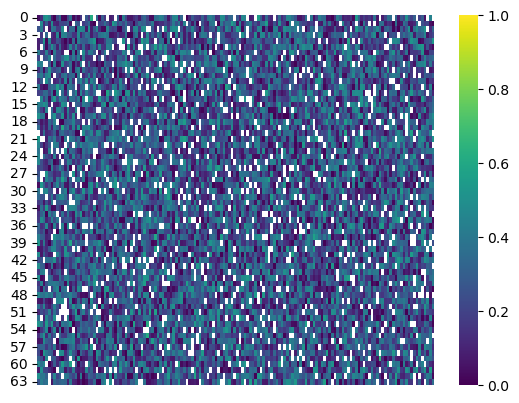

In [41]:
sns.heatmap(dX, cmap="viridis",vmin=0,vmax=1,mask=mask.detach().numpy(),xticklabels=False)

In [42]:
os.listdir(data_path)

['processed', 'raw']

In [43]:
scbc = pd.read_csv(data_path+"//processed//protein_quant_merged.txt",delimiter="\t")
scbc.isna().sum().sum()

np.int64(104200)

In [44]:
npscbc = scbc.to_numpy()
np.isnan(npscbc).sum()


np.int64(104200)

In [45]:
scbc_min = np.nanmin(npscbc, axis=1, keepdims=True)  # minimum among non-NaN
scbc_max = np.nanmax(npscbc, axis=1,keepdims=True)  # maximum among non-NaN
print(scbc_max.shape,scbc_min.shape,np.isnan(scbc_max).sum(), np.isnan(scbc_min).sum())

(10439, 1) (10439, 1) 0 0


In [46]:
npscbc_scaled = (npscbc - scbc_min) /(scbc_max - scbc_min + 1e-8)

In [47]:
np.isnan(npscbc_scaled).sum()

np.int64(104200)

In [48]:
npscbc_scaled.max(axis=1)

array([ 1., nan,  1., ...,  1.,  1., nan])

In [49]:
scbc_dataset = ProteinDataset(npscbc_scaled, row_ids=None)


Protein Dataset is passed to memory
No Protein Symbols were identified


In [50]:
scbc_loader = DataLoader(scbc_dataset, batch_size=64, shuffle=True)

In [51]:
data_scbc, mask_scbc, idx = next(iter(scbc_loader))

In [52]:
data_scbc.shape, mask_scbc.shape

(torch.Size([64, 130]), torch.Size([64, 130]))

In [53]:
data_scbc, mask_scbc

(tensor([[0.5673, 0.6021, 0.6573,  ..., 0.5066, 0.3243, 0.3293],
         [0.8754, 0.8114, 0.6268,  ..., 0.3166, 0.2767, 0.2764],
         [0.7531, 0.7700, 0.4188,  ..., 0.1029, 0.0700, 0.0513],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.3318, 0.1989, 0.1608],
         [0.0667, 0.0000, 0.1639,  ..., 0.8594, 0.6593, 0.6762]]),
 tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]))

In [54]:
model2 = VAE(
    n_features=130,
    latent_dim=32,
    hidden_layer=True,
    hidden_dim=65,
    sigmoid=True
).to(device)
optimizer = optim.Adam(model2.parameters(), lr=0.001)



In [55]:
num_epochs = 3

model2.train()

loss_final = 0
lst = []
data2, mask2 = data_scbc.to(device), mask_scbc.to(device)
print(data2.shape,mask2.shape)
optimizer.zero_grad()

x_mu, x_logvar, z_mu, z_logvar = model2(data2)
print(x_mu.shape, x_logvar.shape)

loss = loss_fun(data2, x_mu, x_logvar, z_mu, z_logvar,lst,mask=mask2,freebits=0.1)
loss.backward()
optimizer.step()
loss_final += loss 
print(f"Epoch {epoch+1}, Loss: {loss_final/len(x_train):.4f}, Rec Loss: {lst[-1]}")

torch.Size([64, 130]) torch.Size([64, 130])
torch.Size([64, 130]) torch.Size([64, 130])
Epoch 100, Loss: 2.8672, Rec Loss: 4.77090311050415


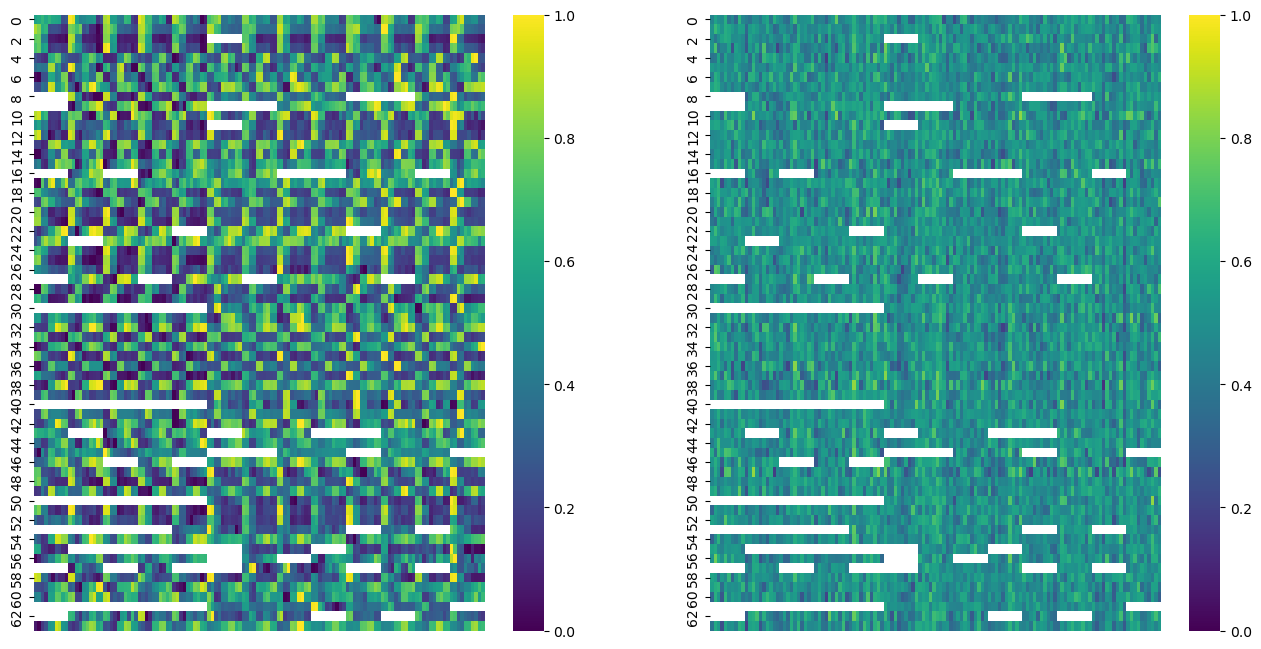

In [56]:
fig, axes = plt.subplots(1,2,figsize=(16,8))
ax1 = sns.heatmap(x_mu.detach().numpy(), cmap="viridis",vmin=0,vmax=1,
                  mask=mask2.detach().numpy(),xticklabels=False,ax=axes[1])
ax2 = sns.heatmap(data2.detach().numpy(), cmap="viridis",vmin=0,vmax=1,
                  mask=mask2.detach().numpy(),xticklabels=False, ax=axes[0])
plt.show()

In [57]:
dX = abs(data2.to("cpu").numpy() - x_mu.detach().numpy())
dX.shape,mask2.detach().numpy()

((64, 130),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False]]))

<Axes: >

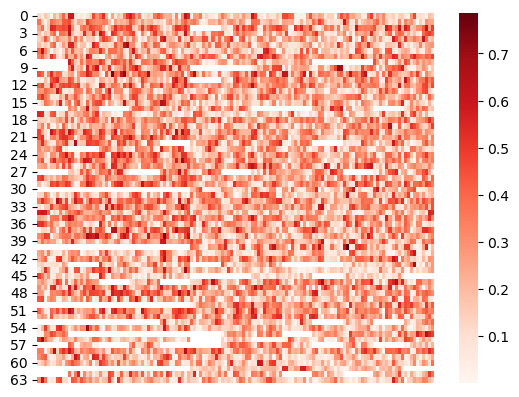

In [58]:
sns.heatmap(dX, cmap="Reds",
                  mask=mask2.detach().numpy(),xticklabels=False)

In [59]:
npscbc_scaled.shape[0]*0.7

7307.299999999999

In [60]:
npscbc_scaled[7308:,].shape

(3131, 130)

In [61]:
train_dataset = ProteinDataset(npscbc_scaled[:7308,],row_ids=None)
test_dataset = ProteinDataset(npscbc_scaled[7308:,],row_ids=None)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified


In [62]:
len(train_loader)

58

# Run models

In [82]:
model3 = VAE(
    n_features=130,
    latent_dim=35,
    hidden_layer=True,
    hidden_dim=70,
    sigmoid=True
).to(device)
optimizer = optim.Adam(model3.parameters(), lr=0.005)

model_name = "model7_35_70"


In [83]:
epoch = 100
model = model3
optimizer = optimizer
freebits = 0.1
batch_size = 128
norm = 0 

hyperparam_str = f"norm{norm}_bits{freebits}_bs{batch_size}_lr{optimizer.param_groups[0]["lr"]}"


# Storage
# for each batch/iteration
batch_dict = {
    "iteration": [],
    "Train total Loss": [],
    "Train KL Loss": [], 
    "Train Rec Loss": []
    }

# for each epoch
epoch_dict = {
    "epoch": [],
    "Train total Loss": [],
    "Train KL Loss": [], 
    "Train Rec Loss": [],
    "Val total Loss": [],
    "Val KL Loss": [],
    "Val Rec Loss": []
    }


for epoch in tqdm(range(epoch+1)):
    
    
    # initialize the loss metrics at epoch zero
    if epoch == 0:
        print(f"Performing pre-training evaluation on the model in epoch {epoch}")
        val_loss, val_kl, val_rl = 0,0,0
        model.eval()
        with torch.inference_mode(): # it doesnt update parameters 
            lst = []
            for val_batch, t_mask, tidx in test_loader:
                x_mu, x_logvar, z_mu, z_logvar = model(val_batch)
                loss = loss_fun(val_batch, x_mu, x_logvar, z_mu, z_logvar,lst,mask=t_mask,freebits=freebits)
                val_loss += loss.detach().item()
                val_kl += lst[-1]
                val_rl += lst[-2]
            
            val_loss = val_loss/len(test_loader)
            val_kl = val_kl/len(test_loader)
            val_rl = val_rl/len(test_loader)
            
            epoch_dict["epoch"].append(epoch)
            epoch_dict["Train total Loss"].append(val_loss)
            epoch_dict["Train KL Loss"].append(val_kl)
            epoch_dict["Train Rec Loss"].append(val_rl)
            epoch_dict["Val total Loss"].append(val_loss)
            epoch_dict["Val KL Loss"].append(val_kl)
            epoch_dict["Val Rec Loss"].append(val_rl)
        
        print(f"\nVal loss: {val_loss:.3f}| Val KL: {val_kl} | Val Rec: {val_rl:.3f}\n")
    
    # begin training the model from iteration 0 and after epoch 0 
    else:
        print(f"Epoch {epoch}\n--------------------")
        train_loss, train_kl, train_rl = 0,0,0
        lst = [] # this list stores the averaged losses/batch that are computed from the loss
        iter = 0			
        for batch, (xbatch, xmask, xidx) in enumerate(train_loader):
            model.train()
            # device
            xbatch, xmask = xbatch.to(device), xmask.to(device)

            #
            optimizer.zero_grad()

            x_mu, x_logvar, z_mu, z_logvar = model(xbatch)

            loss = loss_fun(xbatch, x_mu, x_logvar, z_mu, z_logvar,lst,mask=xmask,freebits=freebits)
            train_loss += loss.detach().item()
            train_kl += lst[-1]
            train_rl += lst[-2]

            batch_loss = loss.detach().item()
            batch_kl = lst[-1]
            batch_rl = lst[-2]

            loss.backward()
                    
            # Optional gradient clipping
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=norm)
            optimizer.step()

            # update the batch dictionary - no val since #iterations are not the same 
            batch_dict["iteration"].append(iter)
            batch_dict["Train total Loss"].append(batch_loss)
            batch_dict["Train KL Loss"].append(batch_kl)
            batch_dict["Train Rec Loss"].append(batch_rl)

            iter +=1

            # print every round of 10 batches the losses - smooths the results 
            if batch % 10 == 0:
                print(f"Iter {batch} and a total {batch*batch_size}/{len(train_loader.dataset)} proteins have passed.")
                print(f"Current Loss: {train_loss/(batch+1)} | KL Loss: {train_kl/(batch+1)}| Rec Loss: {train_rl/(batch+1)}")


        # calculate per epoch the metrics - divide by number of batches 
        train_loss = train_loss/len(train_loader)
        train_kl = train_kl/len(train_loader)
        train_rl = train_rl/len(train_loader)
        
        # add them to the dictionary 
        epoch_dict["epoch"].append(epoch)
        epoch_dict["Train total Loss"].append(train_loss)
        epoch_dict["Train KL Loss"].append(train_kl)
        epoch_dict["Train Rec Loss"].append(train_rl)
        

        # pass the validation set to the VAE 
        val_loss, val_kl, val_rl = 0,0,0
        model.eval()
        with torch.inference_mode(): # it doesnt update parameters based on gradients 
            lst = []
            for val_batch, t_mask, tidx in test_loader:

                x_mu, x_logvar, z_mu, z_logvar = model(val_batch)
                loss = loss_fun(val_batch, x_mu, x_logvar, z_mu, z_logvar,lst,mask=t_mask,freebits=freebits)
                val_loss += loss.detach().item()
                val_kl += lst[-1]
                val_rl += lst[-2]
            
            # divide by all the batches of val set to get epoch metrics 
            val_loss = val_loss/len(test_loader)
            val_kl = val_kl/len(test_loader)
            val_rl = val_rl/len(test_loader)

            epoch_dict["Val total Loss"].append(val_loss)
            epoch_dict["Val KL Loss"].append(val_kl)
            epoch_dict["Val Rec Loss"].append(val_rl)

        ## Print out what's happening
        print(f"\nTrain loss: {train_loss:.3f}|Train Rec: {train_rl:.3f} | Val loss: {val_loss:.3f}, Val Rec: {val_rl:.3f}\n")

  0%|          | 0/101 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 3.380| Val KL: 2.427384920120239 | Val Rec: 0.952

Epoch 1
--------------------
Iter 0 and a total 0/7308 proteins have passed.
Current Loss: 5.7144975662231445 | KL Loss: 4.757108688354492| Rec Loss: 0.9573889970779419
Iter 10 and a total 1280/7308 proteins have passed.
Current Loss: 3.590355092828924 | KL Loss: 2.9130149321122603| Rec Loss: 0.6773401498794556
Iter 20 and a total 2560/7308 proteins have passed.
Current Loss: 3.160877670560564 | KL Loss: 2.697474036897932| Rec Loss: 0.4634036279859997
Iter 30 and a total 3840/7308 proteins have passed.
Current Loss: 2.976856070180093 | KL Loss: 2.6191248663010134| Rec Loss: 0.3577311985915707
Iter 40 and a total 5120/7308 proteins have passed.
Current Loss: 2.8578555525802987 | KL Loss: 2.579604212830706| Rec Loss: 0.2782513391135669
Iter 50 and a total 6400/7308 proteins have passed.
Current Loss: 2.775394173229442 | KL Loss: 2.5569354038612517| Rec Loss: 0.21845877

Some possible explanations behind the lower validation error is linked mostly to the fact that the validation error is calculated after the training loss error. So the **first** test batch might start with an error of 2.77. Also the train error ia averaged starting from very high values. Furthermore validation set is not regularlized during predictions. 

In [65]:


def plot_training_loss_sp(ax, minibatch_losses, num_epochs, averaging_iterations=20, custom_label=''):
    """
    Plots batch and batch-average loss in x axis.
    It returns matplotlib ax plots, so it can be used in subplots.
    Based on Sebastian Racschka's code. 
    
    Parameters:
      ax: matplotlib axis on which to plot.
      minibatch_losses: list/array of loss values per iteration.
      num_epochs: total number of epochs.
      averaging_iterations: window size for computing the running average.
      custom_label: A label for the specific loss type.
    """
    iter_per_epoch = len(minibatch_losses) // num_epochs

    # Plot raw loss
    ax.plot(range(len(minibatch_losses)),
            minibatch_losses,
            label=f'Minibatch Loss{custom_label}',
            color="green", alpha=0.8)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')

    # Set y-axis limits if losses are positive (adjust based on later iterations)
    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    # set y-axis limits
    if np.min(minibatch_losses) > 0:
        ax.set_ylim([
            np.min(minibatch_losses[num_losses:]) * 0.98,
            np.max(minibatch_losses[num_losses:]) * 1.02
        ])

    # Plot running average of the loss
    running_avg = np.convolve(minibatch_losses,
                              np.ones(averaging_iterations) / averaging_iterations,
                              mode='valid')
    ax.plot(running_avg,
            label=f'Running Average{custom_label}',
            color="purple")
    ax.legend()

    # Create a second x-axis for epochs.
    ax2 = ax.twiny()
    new_labels = list(range(num_epochs + 1))
    new_positions = [e * iter_per_epoch for e in new_labels]
    
    # Show only every 5th label 
    ax2.set_xticks(new_positions[::5])
    ax2.set_xticklabels(new_labels[::5])
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax.get_xlim())
    
    plt.tight_layout()


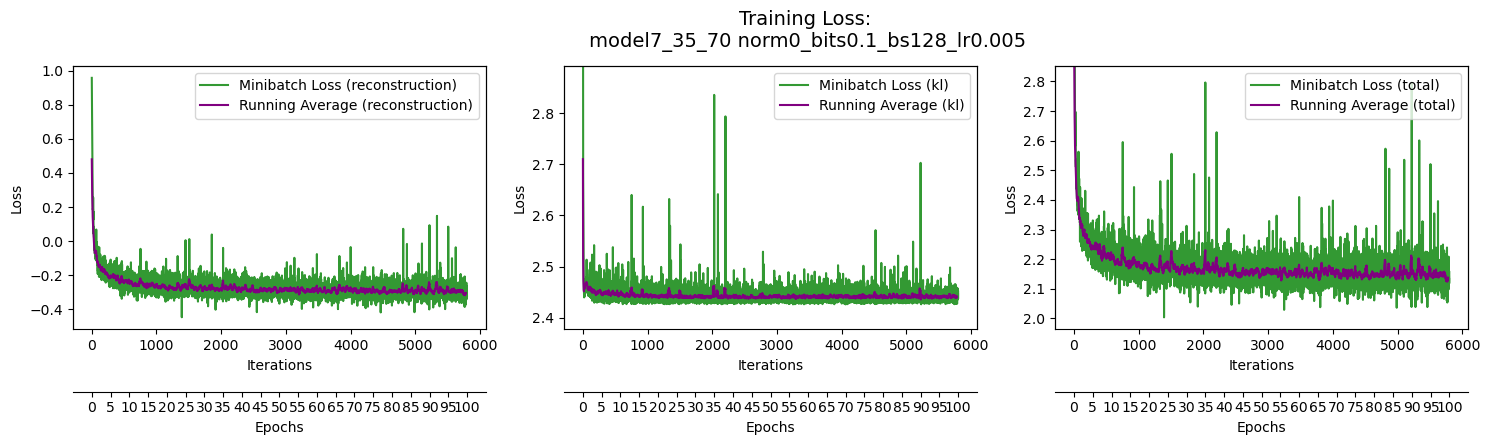

In [84]:
fig, axes = plt.subplots(1,3,figsize=(15,4))

plot_training_loss_sp(axes[0], batch_dict["Train Rec Loss"], epoch, averaging_iterations=20, custom_label=" (reconstruction)")
plot_training_loss_sp(axes[1], batch_dict["Train KL Loss"], epoch, averaging_iterations=20, custom_label=" (kl)")
plot_training_loss_sp(axes[2], batch_dict["Train total Loss"], epoch, averaging_iterations=20, custom_label=" (total)")

fig.suptitle(f"Training Loss:\n {model_name} {hyperparam_str}",
             y=1.1,x=.54,
             fontsize=14)
plt.subplots_adjust(hspace=0.35)  # Adjust the value as needed

path = os.getcwd() + f"\\figures\\{model_name}_trainloss_curve.png"

plt.savefig(path, dpi=600, bbox_inches="tight")
plt.show()

In [122]:
# len(train_loader)

In [85]:
epoch_df = pd.DataFrame(epoch_dict)
epoch_df = (epoch_df
            .assign(
                rec_dif = np.abs(epoch_df["Val Rec Loss"] - epoch_df["Train Rec Loss"]),
                kl_dif = np.abs(epoch_df["Val KL Loss"] - epoch_df["Train KL Loss"]),
                total_dif = epoch_df["Val total Loss"] - epoch_df["Train total Loss"]

            ))
epoch_df.head(20)

,epoch,Train total Loss,Train KL Loss,Train Rec Loss,Val total Loss,Val KL Loss,Val Rec Loss,rec_dif,kl_dif,total_dif
0,0,3.379691,2.427385,0.952306,3.379691,2.427385,0.952306,0.000000,0.000000,0.000000
1,1,2.729640,2.546393,0.183247,2.355199,2.427814,-0.072614,0.255861,0.118580,-0.374441
2,2,2.365782,2.459620,-0.093838,2.293181,2.456671,-0.163490,0.069652,0.002949,-0.072601
3,3,2.299537,2.455779,-0.156241,2.266301,2.435812,-0.169511,0.013270,0.019967,-0.033236
4,4,2.270998,2.448274,-0.177276,2.240985,2.442781,-0.201796,0.024519,0.005493,-0.030012
5,5,2.248038,2.450605,-0.202567,2.252212,2.430691,-0.178479,0.024087,0.019914,0.004174
6,6,2.243105,2.447572,-0.204467,2.263800,2.427561,-0.163762,0.040705,0.020010,0.020695
7,7,2.236182,2.448862,-0.212680,2.275064,2.426247,-0.151183,0.061498,0.022615,0.038883
8,8,2.216547,2.447362,-0.230815,2.235625,2.453530,-0.217905,0.012910,0.006167,0.019077
9,9,2.222406,2.447649,-0.225243,2.205787,2.431773,-0.225986,0.000743,0.015876,-0.016619


In [124]:
# # plot validation error vs training error per epoch
# custom_label = "Reconstruction Error"
# fig, ax = plt.subplots(2,1,figsize=(10,7), sharex=True)
# # first line of the ax plot 
# ax1 = sns.lineplot(
#     epoch_df,x=epoch_df["epoch"], y=epoch_df["Train Rec Loss"],
#     lw = 2, color = "green", alpha = 0.6, label="Training Error",
#     marker = "o",ax=ax[0]
# )
# ax1 = sns.lineplot(
#     epoch_df,x=epoch_df["epoch"], y=epoch_df["Val Rec Loss"],
#     lw = 2, color = "purple", alpha = 0.7, label="Validation Error",
#     marker = "o",ax=ax[0]
# )
# ax1.set_title(f"{model_name}- {custom_label}", fontsize = 14)


# # add second line - share x axis 
# # ax2 = ax1.twinx()
# ax2 = sns.lineplot(
#     epoch_df, x=epoch_df["epoch"], y=epoch_df["rec_dif"],
#     color = "black", ls="--", marker = "o", label = "Absol. Diff",
#     ax=ax[1]
# )

# #share same axis
# ax2.sharex(ax1)
# plt.show()

In [125]:
data_path

'c:\\Users\\gpano\\Desktop\\github_py\\proteomics_latent_space\\data'

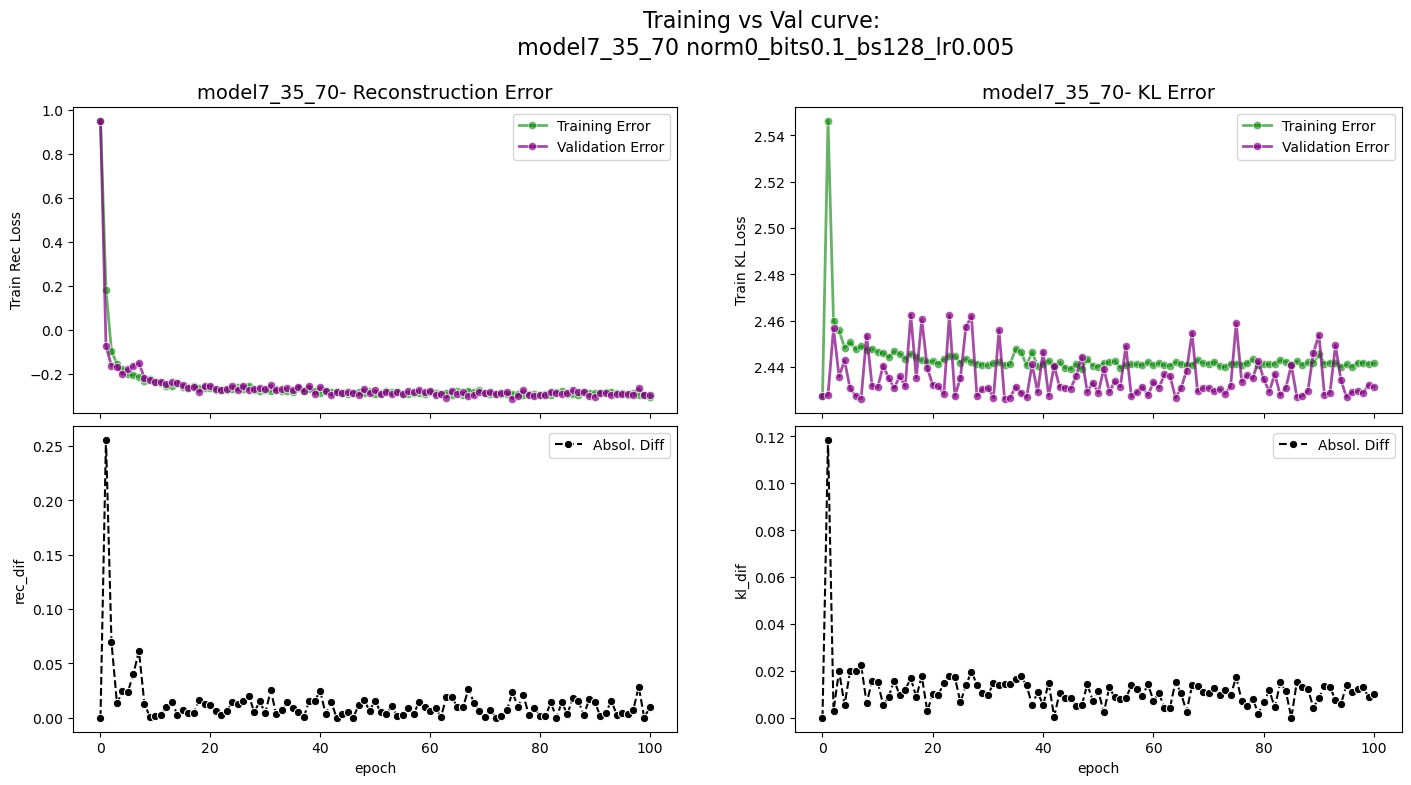

In [87]:
# plot validation error vs training error per epoch
custom_label1 = "Reconstruction Error"
custom_label2 = "KL Error"

# create subfigures
fig = plt.figure(layout="constrained", figsize=(14,7))
subfigs = fig.subfigures(1,2,wspace=0.07)

# first subfigure of the ax plot 
ax = subfigs[0].subplots(2,1, sharex=True)

ax1 = sns.lineplot(
    epoch_df,x=epoch_df["epoch"], y=epoch_df["Train Rec Loss"],
    lw = 2, color = "green", alpha = 0.6, label="Training Error",
    marker = "o",ax=ax[0]
)
ax1 = sns.lineplot(
    epoch_df,x=epoch_df["epoch"], y=epoch_df["Val Rec Loss"],
    lw = 2, color = "purple", alpha = 0.7, label="Validation Error",
    marker = "o",ax=ax[0]
)
ax1.set_title(f"{model_name}- {custom_label1}", fontsize = 14)

# add second line - share x axis 
# ax2 = ax1.twinx()
ax2 = sns.lineplot(
    epoch_df, x=epoch_df["epoch"], y=epoch_df["rec_dif"],
    color = "black", ls="--", marker = "o", label = "Absol. Diff",
    ax=ax[1]
)

# first subfigure of the ax plot 
ax = subfigs[1].subplots(2,1, sharex=True)

ax1 = sns.lineplot(
    epoch_df,x=epoch_df["epoch"], y=epoch_df["Train KL Loss"],
    lw = 2, color = "green", alpha = 0.6, label="Training Error",
    marker = "o",ax=ax[0]
)
ax1 = sns.lineplot(
    epoch_df,x=epoch_df["epoch"], y=epoch_df["Val KL Loss"],
    lw = 2, color = "purple", alpha = 0.7, label="Validation Error",
    marker = "o",ax=ax[0]
)
ax1.set_title(f"{model_name}- {custom_label2}", fontsize = 14)

# add second line - share x axis 
# ax2 = ax1.twinx()
ax2 = sns.lineplot(
    epoch_df, x=epoch_df["epoch"], y=epoch_df["kl_dif"],
    color = "black", ls="--", marker = "o", label = "Absol. Diff",
    ax=ax[1]
)

fig.suptitle(f"Training vs Val curve:\n {model_name} {hyperparam_str}",
             y=1.1,x=.54,
             fontsize=16)


# save figures 
path = os.getcwd() + f"\\figures\\{model_name}_train_val_epoch_curve.png"
plt.savefig(path, dpi=600, bbox_inches="tight")
plt.show()

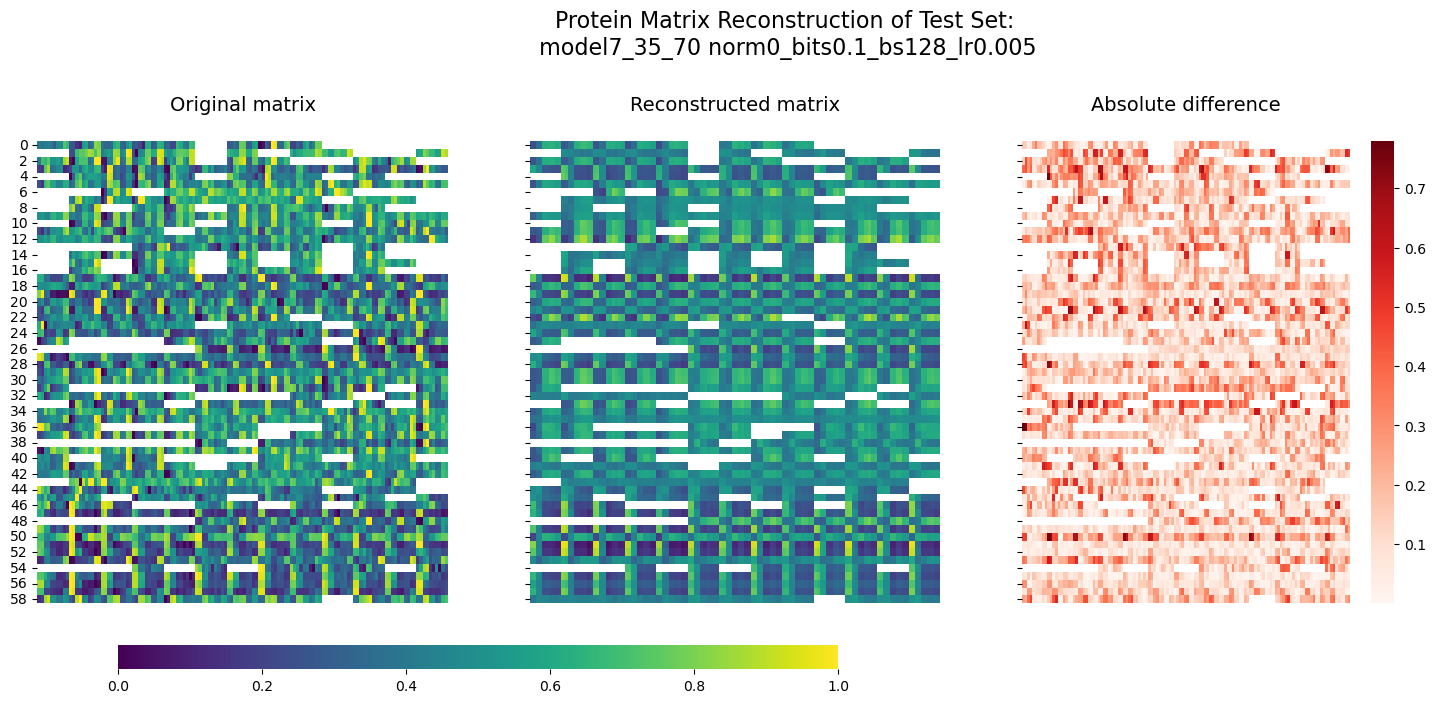

In [89]:
# reoconstructions of the final model - visual inspections 
# based on the final batch of the val test. 
# https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error
# # find a way to sample correct matrices based on index 
# Xorig =  
# Xrec = 

fig, axes = plt.subplots(1,3,figsize=(18,6),sharey=True)

ax1 = sns.heatmap(val_batch.detach().numpy(), cmap="viridis",vmin=0,vmax=1,
                  mask=t_mask.detach().numpy(),xticklabels=False, ax=axes[0],
                  cbar = False)

ax2 = sns.heatmap(x_mu.detach().numpy(), cmap="viridis",vmin=0,vmax=1,
                  mask=t_mask.detach().numpy(),xticklabels=False,ax=axes[1],
                  cbar_ax=fig.add_axes([.17, 0, .4, .04]),
                  cbar_kws={"orientation": "horizontal"})

dX = np.abs(val_batch.detach().numpy() - x_mu.detach().numpy())
ax3 = sns.heatmap(dX, cmap="Reds",
                  mask=t_mask.detach().numpy(),xticklabels=False, ax=axes[2])
ax1.set_title("Original matrix", fontsize = 14, y=1.05)
ax2.set_title("Reconstructed matrix", fontsize = 14, y=1.05)
ax3.set_title("Absolute difference", fontsize = 14, y=1.05)

fig.suptitle(f"Protein Matrix Reconstruction of Test Set:\n {model_name} {hyperparam_str}",
             y=1.1,x=.54,
             fontsize=16)

# save figures 
path = os.getcwd() + f"\\figures\\{model_name}_matrix_rec.png"
plt.savefig(path, dpi=600, bbox_inches="tight")


plt.show()

In [ ]:
# get KL/dimension for the val set


# fastai

In [128]:
# from fastai.vision.learner import Learner
# from fastai.callback.schedule import lr_find
# from fastai.vision.data import DataLoaders
# from fastai.vision.all import *


In [129]:
# # make some changes to the dataloaders - fastai takes only one input 
# def custom_collate(batch):
#     """Removes `xmask` and `xidx` from each batch."""
#     xbatch = [item[0] for item in batch]  # Extract only xbatch
#     # return torch.stack(xbatch)  # Stack into a batch tensor
#     return (torch.stack(xbatch),)

# new_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, collate_fn=custom_collate)
# new_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, collate_fn=custom_collate)

# list(train_loader)
# # Convert PyTorch DataLoaders into FastAI DataLoaders
# dls = DataLoaders(new_train_loader, new_test_loader)
# # dls = DataLoaders.from_dataloaders(new_train_loader, new_test_loader)


# # Create a FastAI Learner
# learn = Learner(dls, model3, loss_func=loss_fun, opt_func=Adam)

# # Find the optimal learning rate
# lr_min, lr_steep = learn.lr_find(suggest_funcs=(True, True))

In [130]:
def find_learning_rate(model, train_loader, loss_fn, optimizer, init_lr=1e-7, final_lr=.1, beta=0.98):
    """
    Implements a Learning Rate Finder like in the Leslie paper.
    
    Parameters:
        - model: PyTorch model
        - train_loader: DataLoader for training data
        - loss_fn: Loss function
        - optimizer: PyTorch optimizer
        - init_lr: Initial learning rate
        - final_lr: Maximum learning rate 
        - beta: Smoothing factor (Leslie used 0.98)
    
    Returns:
        - lrs: List of learning rates 
        - losses: List of losses 
    """

    num_batches = len(train_loader) - 1
    lr_mult = (final_lr / init_lr) ** (1 / num_batches)
    lrs, losses = [], []

    # Set initial lr and loss 
    optimizer.param_groups[0]["lr"] = init_lr
    avg_loss, best_loss = 0.0, float("inf")

    model.train()
    
    for batch_idx, (xbatch, xmask, _) in enumerate(train_loader):
        xbatch, xmask = xbatch.to(device), xmask.to(device)
        optimizer.zero_grad()
        
        # Forward and Backward pass for lr
        x_mu, x_logvar, z_mu, z_logvar = model(xbatch)
        loss = loss_fn(xbatch, x_mu, x_logvar, z_mu, z_logvar, lst=[], mask=xmask, freebits=0.5)
        
        loss.backward()
        optimizer.step()

        # Calculate the loss for the specific lr 
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta ** (batch_idx + 1))
        
        # Put lr and metrics in the lists 
        lrs.append(optimizer.param_groups[0]["lr"])
        losses.append(smoothed_loss)

        # Check if loss goes very hign or if lr has hit max value
        
        if smoothed_loss < best_loss:
            best_loss = smoothed_loss
        elif smoothed_loss > best_loss * 3:
            break
        elif optimizer.param_groups[0]["lr"] > 1:
            break
        # Increase LR exponentially
        optimizer.param_groups[0]["lr"] *= lr_mult
    
    # Plot Learning Rate Finder Curve and steepest descend of Loss 
    plt.figure(figsize=(8, 6))
    plt.plot(lrs, losses)
    plt.xscale("log")
    plt.xlabel("Learning Rate (Log Scale)")
    plt.ylabel("Loss")
    plt.title("Learning Rate Finder")
    plt.show()

    # could return the index of steepest descend though. 
    # returns the index of the lr that is linked to the smallest loss. 
    return np.nanargmin(losses)

In [71]:
model3 = VAE(
    n_features=130,
    latent_dim=25,
    hidden_layer=True,
    hidden_dim=65,
    sigmoid=True
).to(device)
optimizer = optim.Adam(model3.parameters(), lr=0.001)


model_name = "model0"

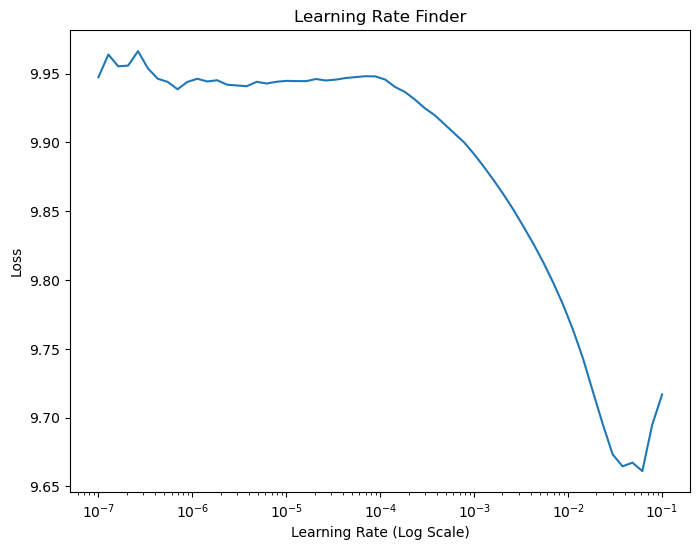

np.int64(55)

In [72]:
find_learning_rate(model3, train_loader, loss_fun, optimizer, init_lr=1e-7, final_lr=.1, beta=0.98)

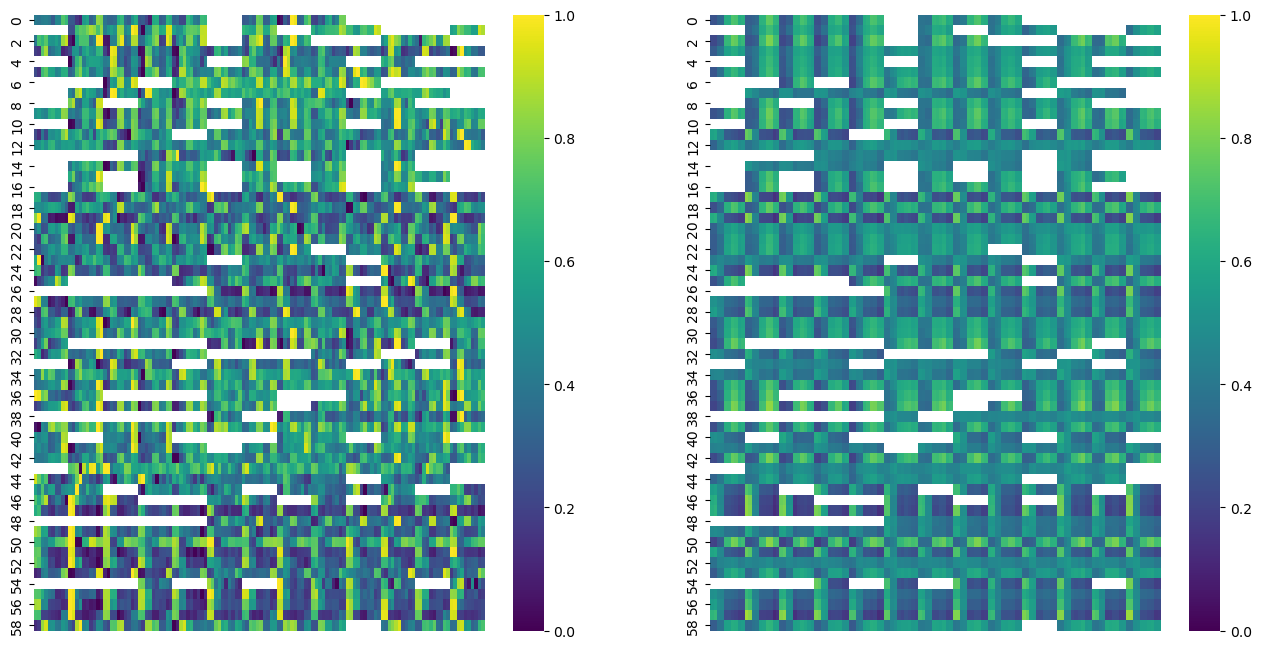

In [90]:
fig, axes = plt.subplots(1,2,figsize=(16,8))
ax1 = sns.heatmap(x_mu.detach().numpy(), cmap="viridis",vmin=0,vmax=1,
                  mask=t_mask.detach().numpy(),xticklabels=False,ax=axes[1])
ax2 = sns.heatmap(val_batch.detach().numpy(), cmap="viridis",vmin=0,vmax=1,
                  mask=t_mask.detach().numpy(),xticklabels=False, ax=axes[0])
plt.show()

In [92]:
dX = abs(val_batch.to("cpu").numpy() - x_mu.detach().numpy())
dX.shape

(59, 130)

In [93]:
dX/dX.max(axis=1,keepdims=True)

array([[0.2076437 , 0.17981088, 0.13901407, ..., 0.95371515, 0.87395877,
        0.8819373 ],
       [0.4093449 , 0.40618026, 0.557644  , ..., 0.0822402 , 0.5261327 ,
        0.45185456],
       [0.23674728, 0.65490067, 0.49551946, ..., 1.        , 0.9103712 ,
        0.920565  ],
       ...,
       [1.        , 0.9903864 , 0.0749492 , ..., 0.24939172, 0.07187134,
        0.0356069 ],
       [0.15386668, 0.07654806, 0.7273488 , ..., 0.17683524, 0.09175178,
        0.16827218],
       [0.26986006, 0.20131518, 0.7701712 , ..., 0.38402608, 0.1850873 ,
        0.26212654]], dtype=float32)

<Axes: >

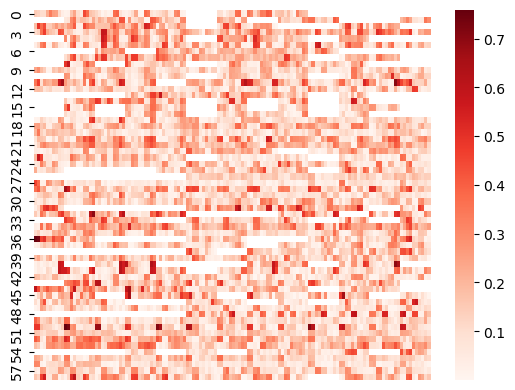

In [94]:
sns.heatmap(dX, cmap="Reds",
                  mask=t_mask.detach().numpy(),xticklabels=False)

<Axes: >

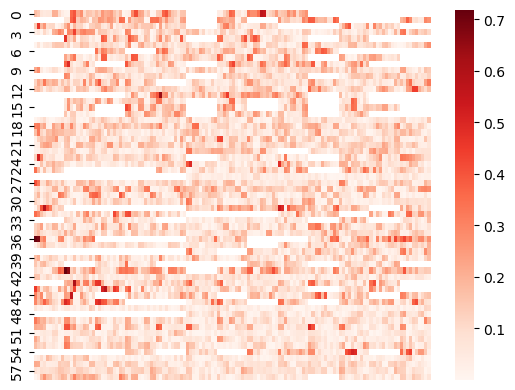

In [139]:
sns.heatmap(dX, cmap="Reds",
                  mask=t_mask.detach().numpy(),xticklabels=False)

# Run complex model

In [131]:

# Model class
class VAE2(nn.Module):
    def __init__(self, 
                 n_features: int,
                 latent_dim: int,
                 hidden_layer : bool = False,
                 hidden_dim_1: int = None,
                 hidden_dim_2: int = None,
                 sigmoid = True):
        """
        Parameters:
        ------------------
        n_features : int
            Number of input features (columns of the protein table e.g. 150).
        latent_dim : int
            Size of latent space (e.g., 20).
        hidden_layer : bool
            A boolean value indicating whether a hidden layer is added or not.
            By default is False
        hidden_dim : int
            Number of neurons in the hidden layer (e.g., 50), if there is a hidden
            layer. Default value is None 
        sigmoid : bool
            If True, applies a Sigmoid activation to the decoder output. Usefull
            when data is scaled to (0,1). Not recommended for raw measurements. 
        
        Information
        ------------------
        The VAE has maximum one hidden layer with LeakyReLu activation function
        to the encoder. The decoder is either linear or a sigmoid activation function
        is applied if scaled data is used. 
        For Regularlization I used dropout rate equal to 0.2
        I added the choice of a model without hidden layer and with a linear 
        transformation if the data  is unscaled and raw values might be used. 
        """ 
        super().__init__()

        # Load the parameters 
        self.n_features = n_features
        self.hidden_layer = hidden_layer
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        self.latent_dim = latent_dim
        self.sigmoid = sigmoid

        # the encoder module
        if hidden_layer == False: # this is linear transformation 
            self.encoder = nn.Sequential(
            # one linear Layer the latent Space: z_mu and z_logvar
            nn.Linear(self.n_features, self.latent_dim * 2)
        )
        else:
            self.encoder = nn.Sequential(
            # one hidden layer
            nn.Linear(in_features=self.n_features, out_features=self.hidden_dim_1),
            nn.Dropout(0.2),
            nn.BatchNorm1d(self.hidden_dim_1),
            nn.LeakyReLU(.1),
            nn.Linear(in_features=self.hidden_dim_1, out_features=self.hidden_dim_2),
            nn.Dropout(0.2),
            nn.BatchNorm1d(self.hidden_dim_2),
            nn.LeakyReLU(.1),

            # Latent Space: z_mu and z_logvar 
            nn.Linear(self.hidden_dim_2, self.latent_dim * 2)
            )
       
        
        # decoder module
        # No hidden Layers - separate the two heads
        if hidden_layer == False:
            decoder_list =[
            # one linear Layer the latent Space: z_mu and z_logvar
            nn.Linear(latent_dim, n_features)]
                      
            if sigmoid == True:
                decoder_list.append(nn.Sigmoid())
            
            self.head_mu = nn.Sequential(*decoder_list)
            self.head_logvar = nn.Linear(latent_dim, n_features)


        # Decoder with two hidden layer 
        else:
            # Common corpus of the decoder
            self.decoder_common = nn.Sequential(
            # From latent to hidden 
            nn.Linear(self.latent_dim, self.hidden_dim_2),
            nn.Dropout(0.2),
            nn.BatchNorm1d(self.hidden_dim_2),
            nn.LeakyReLU(.1),
            nn.Linear(self.hidden_dim_2, self.hidden_dim_1),
            nn.Dropout(0.2),
            nn.BatchNorm1d(self.hidden_dim_1),
            nn.LeakyReLU(.1))

            # Decoder output separated in two heads: x_mu and x_logvar 
            head_mu_list = [nn.Linear(self.hidden_dim_1, self.n_features)]
            if sigmoid == True:
                head_mu_list.append(nn.Sigmoid())
            
            # unpack the n x_mu variables
            self.head_mu = nn.Sequential(*head_mu_list)
            
            # unpack the n x_logvar variables 
            self.head_logvar = nn.Linear(self.hidden_dim_1, self.n_features)


    def encode(self, x: torch.tensor):
        z_variables = self.encoder(x)
        # unpack mean and logvar of variables (latent_dim * 2) 
        z_mu = z_variables[:, :self.latent_dim]
        z_logvar = z_variables[:, self.latent_dim:]
        return z_mu, z_logvar
    

    def get_latent_variables(self, x, detach = False):
        """
        If detach = True the latent variables are not part of the 
        computation graph. Better for downstream analysis.
        """
        
        z_mu, z_logvar = self.encode(x)
        if detach:
            z_mu = z_mu.detach()
            z_logvar = z_logvar.detach()
        return z_mu, z_logvar


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std # what this does ?
    

    def decode(self, z):
        if self.hidden_layer:
            common_layer = self.decoder_common(z)
            x_mu = self.head_mu(common_layer)
            x_logvar = self.head_logvar(common_layer)
            return x_mu, x_logvar
        else:
            x_mu = self.head_mu(z)
            x_logvar = self.head_logvar(z) 
            return x_mu, x_logvar


    def forward(self, x):
        z_mu, z_logvar = self.encode(x)
        z = self.reparameterize(z_mu, z_logvar)
        x_mu, x_logvar = self.decode(z)
        return x_mu, x_logvar, z_mu, z_logvar


In [191]:
model4 = VAE2(n_features=130,
              latent_dim=30,
              hidden_layer= True,
              hidden_dim_1=75,
              hidden_dim_2=40,
              sigmoid=True).to(device)

optimizer = optim.Adam(model4.parameters(), lr=0.005)

model_name = "model_complex_6_75-40-30"

In [192]:
epoch = 40
model = model4
optimizer = optimizer
freebits = 1
batch_size = 128
norm = 0 

hyperparam_str = f"norm{norm}_bits{freebits}_bs{batch_size}_lr{optimizer.param_groups[0]["lr"]}"


# Storage
# for each batch/iteration
batch_dict = {
    "iteration": [],
    "Train total Loss": [],
    "Train KL Loss": [], 
    "Train Rec Loss": []
    }

# for each epoch
epoch_dict = {
    "epoch": [],
    "Train total Loss": [],
    "Train KL Loss": [], 
    "Train Rec Loss": [],
    "Val total Loss": [],
    "Val KL Loss": [],
    "Val Rec Loss": []
    }


for epoch in tqdm(range(epoch+1)):
    
    
    # initialize the loss metrics at epoch zero
    if epoch == 0:
        print(f"Performing pre-training evaluation on the model in epoch {epoch}")
        val_loss, val_kl, val_rl = 0,0,0
        model.eval()
        with torch.inference_mode(): # it doesnt update parameters 
            lst = []
            for val_batch, t_mask, tidx in test_loader:
                x_mu, x_logvar, z_mu, z_logvar = model(val_batch)
                loss = loss_fun(val_batch, x_mu, x_logvar, z_mu, z_logvar,lst,mask=t_mask,freebits=freebits)
                val_loss += loss.detach().item()
                val_kl += lst[-1]
                val_rl += lst[-2]
            
            val_loss = val_loss/len(test_loader)
            val_kl = val_kl/len(test_loader)
            val_rl = val_rl/len(test_loader)
            
            epoch_dict["epoch"].append(epoch)
            epoch_dict["Train total Loss"].append(val_loss)
            epoch_dict["Train KL Loss"].append(val_kl)
            epoch_dict["Train Rec Loss"].append(val_rl)
            epoch_dict["Val total Loss"].append(val_loss)
            epoch_dict["Val KL Loss"].append(val_kl)
            epoch_dict["Val Rec Loss"].append(val_rl)
        
        print(f"\nVal loss: {val_loss:.3f}| Val KL: {val_kl} | Val Rec: {val_rl:.3f}\n")
    
    # begin training the model from iteration 0 and after epoch 0 
    else:
        print(f"Epoch {epoch}\n--------------------")
        train_loss, train_kl, train_rl = 0,0,0
        lst = [] # this list stores the averaged losses/batch that are computed from the loss
        iter = 0			
        for batch, (xbatch, xmask, xidx) in enumerate(train_loader):
            model.train()
            # device
            xbatch, xmask = xbatch.to(device), xmask.to(device)

            #
            optimizer.zero_grad()

            x_mu, x_logvar, z_mu, z_logvar = model(xbatch)

            loss = loss_fun(xbatch, x_mu, x_logvar, z_mu, z_logvar,lst,mask=xmask,freebits=freebits)
            train_loss += loss.detach().item()
            train_kl += lst[-1]
            train_rl += lst[-2]

            batch_loss = loss.detach().item()
            batch_kl = lst[-1]
            batch_rl = lst[-2]

            loss.backward()
                    
            # Optional gradient clipping
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=norm)
            optimizer.step()

            # update the batch dictionary - no val since #iterations are not the same 
            batch_dict["iteration"].append(iter)
            batch_dict["Train total Loss"].append(batch_loss)
            batch_dict["Train KL Loss"].append(batch_kl)
            batch_dict["Train Rec Loss"].append(batch_rl)

            iter +=1

            # print every round of 10 batches the losses - smooths the results 
            if batch % 10 == 0:
                print(f"Iter {batch} and a total {batch*batch_size}/{len(train_loader.dataset)} proteins have passed.")
                print(f"Current Loss: {train_loss/(batch+1)} | KL Loss: {train_kl/(batch+1)}| Rec Loss: {train_rl/(batch+1)}")


        # calculate per epoch the metrics - divide by number of batches 
        train_loss = train_loss/len(train_loader)
        train_kl = train_kl/len(train_loader)
        train_rl = train_rl/len(train_loader)
        
        # add them to the dictionary 
        epoch_dict["epoch"].append(epoch)
        epoch_dict["Train total Loss"].append(train_loss)
        epoch_dict["Train KL Loss"].append(train_kl)
        epoch_dict["Train Rec Loss"].append(train_rl)
        

        # pass the validation set to the VAE 
        val_loss, val_kl, val_rl = 0,0,0
        model.eval()
        with torch.inference_mode(): # it doesnt update parameters based on gradients 
            lst = []
            for val_batch, t_mask, tidx in test_loader:

                x_mu, x_logvar, z_mu, z_logvar = model(val_batch)
                loss = loss_fun(val_batch, x_mu, x_logvar, z_mu, z_logvar,lst,mask=t_mask,freebits=freebits)
                val_loss += loss.detach().item()
                val_kl += lst[-1]
                val_rl += lst[-2]
            
            # divide by all the batches of val set to get epoch metrics 
            val_loss = val_loss/len(test_loader)
            val_kl = val_kl/len(test_loader)
            val_rl = val_rl/len(test_loader)

            epoch_dict["Val total Loss"].append(val_loss)
            epoch_dict["Val KL Loss"].append(val_kl)
            epoch_dict["Val Rec Loss"].append(val_rl)

        ## Print out what's happening
        print(f"\nTrain loss: {train_loss:.3f}|Train Rec: {train_rl:.3f} | Val loss: {val_loss:.3f}, Val Rec: {val_rl:.3f}\n")

  0%|          | 0/41 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 21.747| Val KL: 20.79441261291504 | Val Rec: 0.952

Epoch 1
--------------------
Iter 0 and a total 0/7308 proteins have passed.
Current Loss: 21.84958839416504 | KL Loss: 20.890056610107422| Rec Loss: 0.9595310688018799
Iter 10 and a total 1280/7308 proteins have passed.
Current Loss: 21.454086997292258 | KL Loss: 20.815170634876598| Rec Loss: 0.6389163028110157
Iter 20 and a total 2560/7308 proteins have passed.
Current Loss: 21.176465715680802 | KL Loss: 20.809133711315337| Rec Loss: 0.36733188159165103
Iter 30 and a total 3840/7308 proteins have passed.
Current Loss: 21.01226597447549 | KL Loss: 20.813038979807207| Rec Loss: 0.19922697074305748
Iter 40 and a total 5120/7308 proteins have passed.
Current Loss: 20.899868476681593 | KL Loss: 20.81107604794386| Rec Loss: 0.08879241718990137
Iter 50 and a total 6400/7308 proteins have passed.
Current Loss: 20.817282620598288 | KL Loss: 20.810022316726982| Rec Loss: 0.

### Complex Metrics

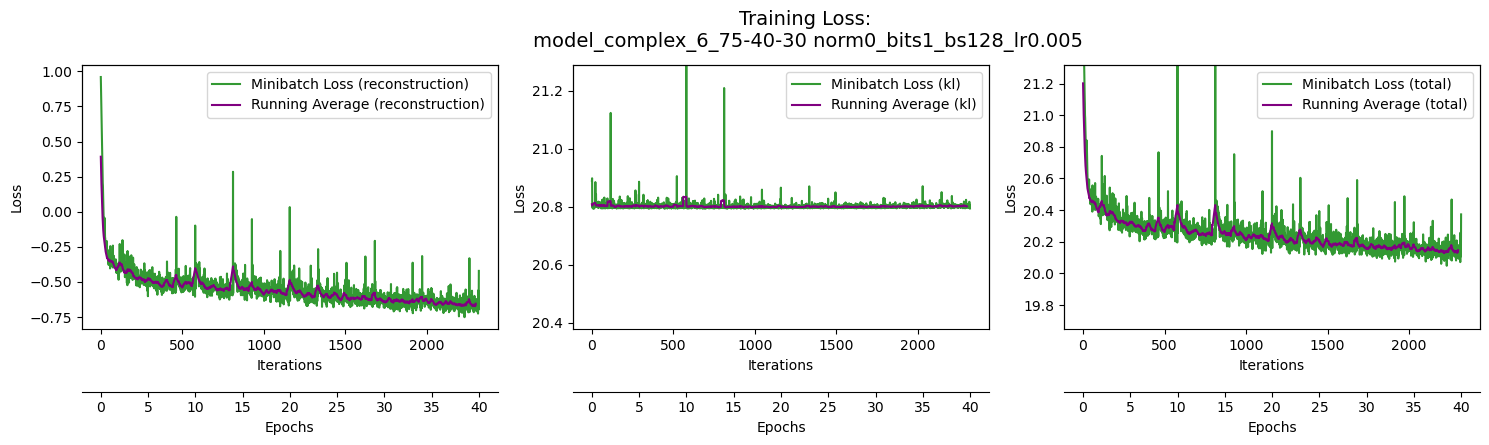

In [193]:
fig, axes = plt.subplots(1,3,figsize=(15,4))

plot_training_loss_sp(axes[0], batch_dict["Train Rec Loss"], epoch, averaging_iterations=20, custom_label=" (reconstruction)")
plot_training_loss_sp(axes[1], batch_dict["Train KL Loss"], epoch, averaging_iterations=20, custom_label=" (kl)")
plot_training_loss_sp(axes[2], batch_dict["Train total Loss"], epoch, averaging_iterations=20, custom_label=" (total)")

fig.suptitle(f"Training Loss:\n {model_name} {hyperparam_str}",
             y=1.1,x=.54,
             fontsize=14)
plt.subplots_adjust(hspace=0.35)  # Adjust the value as needed

path = os.getcwd() + f"\\figures\\{model_name}_trainloss_curve.png"

plt.savefig(path, dpi=600, bbox_inches="tight")
plt.show()

In [194]:
epoch_df = pd.DataFrame(epoch_dict)
epoch_df = (epoch_df
            .assign(
                rec_dif = np.abs(epoch_df["Val Rec Loss"] - epoch_df["Train Rec Loss"]),
                kl_dif = np.abs(epoch_df["Val KL Loss"] - epoch_df["Train KL Loss"]),
                total_dif = epoch_df["Val total Loss"] - epoch_df["Train total Loss"]

            ))
epoch_df.head()

,epoch,Train total Loss,Train KL Loss,Train Rec Loss,Val total Loss,Val KL Loss,Val Rec Loss,rec_dif,kl_dif,total_dif
0,0,21.746740,20.794413,0.952327,21.746740,20.794413,0.952327,0.000000,0.000000,0.000000
1,1,20.773301,20.809091,-0.035789,20.424966,20.794824,-0.369858,0.334068,0.014267,-0.348336
2,2,20.432056,20.809182,-0.377127,20.409857,20.794534,-0.384677,0.007551,0.014648,-0.022199
3,3,20.402906,20.802978,-0.400072,20.358684,20.794421,-0.435736,0.035665,0.008558,-0.044222
4,4,20.360605,20.800986,-0.440381,20.314638,20.795279,-0.480641,0.040260,0.005707,-0.045967


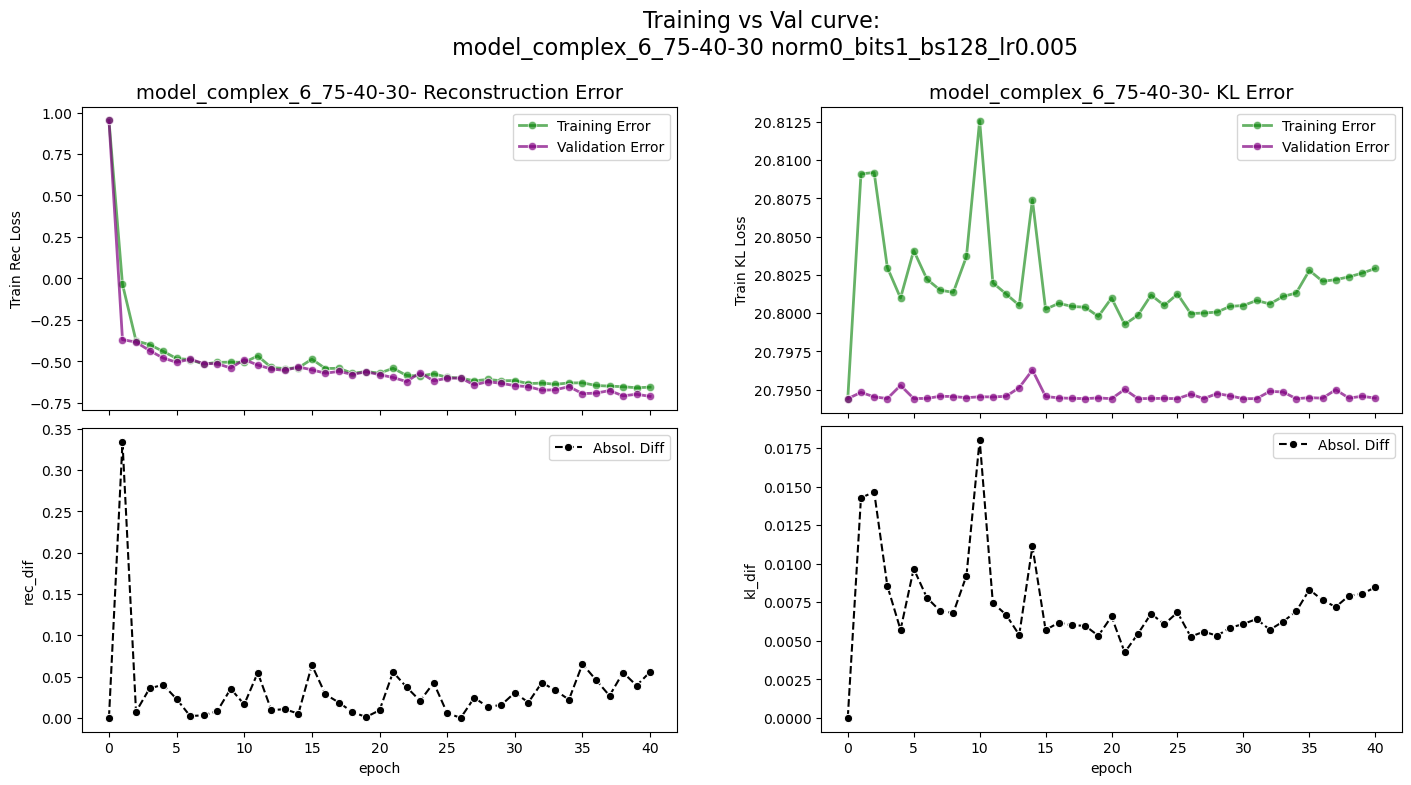

In [195]:
# plot validation error vs training error per epoch
custom_label1 = "Reconstruction Error"
custom_label2 = "KL Error"

# create subfigures
fig = plt.figure(layout="constrained", figsize=(14,7))
subfigs = fig.subfigures(1,2,wspace=0.07)

# first subfigure of the ax plot 
ax = subfigs[0].subplots(2,1, sharex=True)

ax1 = sns.lineplot(
    epoch_df,x=epoch_df["epoch"], y=epoch_df["Train Rec Loss"],
    lw = 2, color = "green", alpha = 0.6, label="Training Error",
    marker = "o",ax=ax[0]
)
ax1 = sns.lineplot(
    epoch_df,x=epoch_df["epoch"], y=epoch_df["Val Rec Loss"],
    lw = 2, color = "purple", alpha = 0.7, label="Validation Error",
    marker = "o",ax=ax[0]
)
ax1.set_title(f"{model_name}- {custom_label1}", fontsize = 14)

# add second line - share x axis 
# ax2 = ax1.twinx()
ax2 = sns.lineplot(
    epoch_df, x=epoch_df["epoch"], y=epoch_df["rec_dif"],
    color = "black", ls="--", marker = "o", label = "Absol. Diff",
    ax=ax[1]
)

# first subfigure of the ax plot 
ax = subfigs[1].subplots(2,1, sharex=True)

ax1 = sns.lineplot(
    epoch_df,x=epoch_df["epoch"], y=epoch_df["Train KL Loss"],
    lw = 2, color = "green", alpha = 0.6, label="Training Error",
    marker = "o",ax=ax[0]
)
ax1 = sns.lineplot(
    epoch_df,x=epoch_df["epoch"], y=epoch_df["Val KL Loss"],
    lw = 2, color = "purple", alpha = 0.7, label="Validation Error",
    marker = "o",ax=ax[0]
)
ax1.set_title(f"{model_name}- {custom_label2}", fontsize = 14)

# add second line - share x axis 
# ax2 = ax1.twinx()
ax2 = sns.lineplot(
    epoch_df, x=epoch_df["epoch"], y=epoch_df["kl_dif"],
    color = "black", ls="--", marker = "o", label = "Absol. Diff",
    ax=ax[1]
)

fig.suptitle(f"Training vs Val curve:\n {model_name} {hyperparam_str}",
             y=1.1,x=.54,
             fontsize=16)


# save figures 
path = os.getcwd() + f"\\figures\\{model_name}_train_val_epoch_curve.png"
plt.savefig(path, dpi=600, bbox_inches="tight")
plt.show()

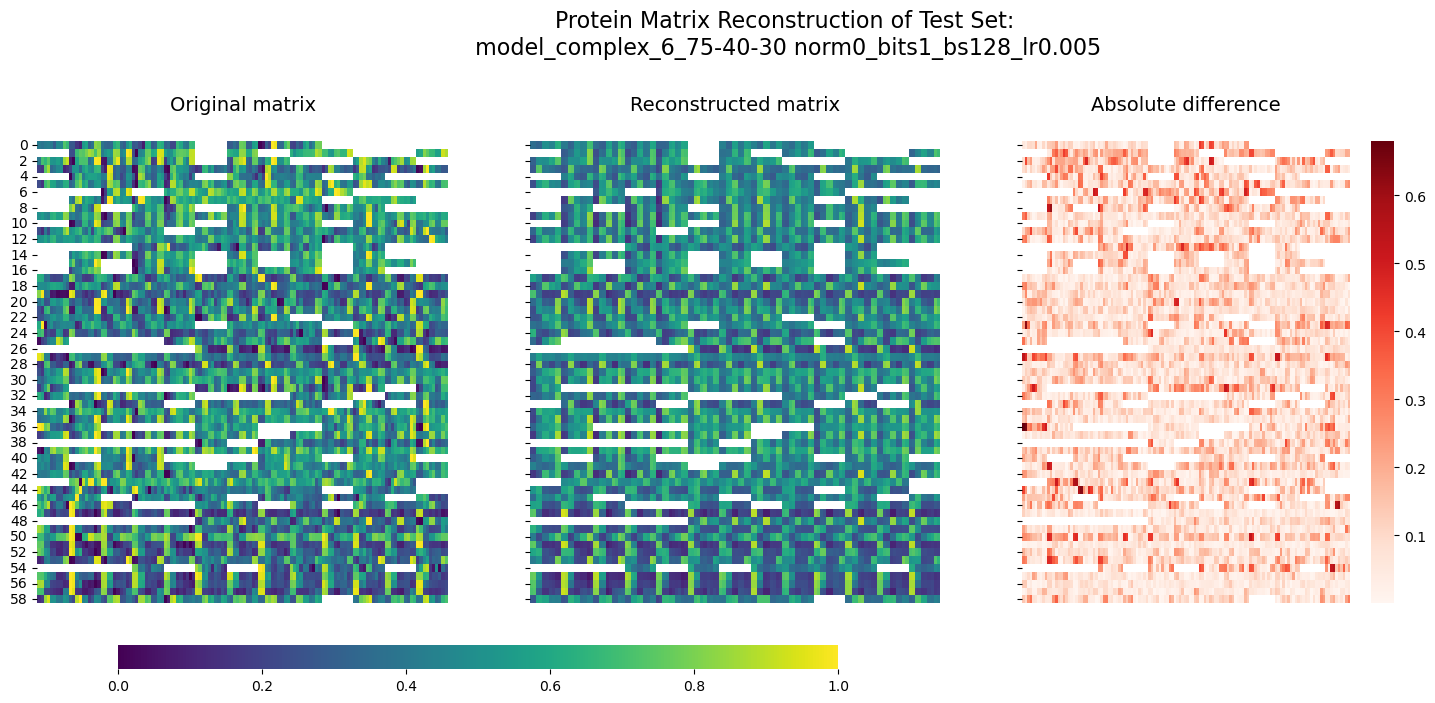

In [ ]:
# reoconstructions of the final model - visual inspections 
# based on the final batch of the val test. 

# # find a way to sample correct matrices based on index 
# Xorig =  
# Xrec = 

fig, axes = plt.subplots(1,3,figsize=(18,6),sharey=True)

ax1 = sns.heatmap(val_batch.detach().numpy(), cmap="viridis",vmin=0,vmax=1,
                  mask=t_mask.detach().numpy(),xticklabels=False, ax=axes[0],
                  cbar = False)

ax2 = sns.heatmap(x_mu.detach().numpy(), cmap="viridis",vmin=0,vmax=1,
                  mask=t_mask.detach().numpy(),xticklabels=False,ax=axes[1],
                  cbar_ax=fig.add_axes([.17, 0, .4, .04]),
                  cbar_kws={"orientation": "horizontal"})

dX = np.abs(val_batch.detach().numpy() - x_mu.detach().numpy())
ax3 = sns.heatmap(dX, cmap="Reds",
                  mask=t_mask.detach().numpy(),xticklabels=False, ax=axes[2])
ax1.set_title("Original matrix", fontsize = 14, y=1.05)
ax2.set_title("Reconstructed matrix", fontsize = 14, y=1.05)
ax3.set_title("Absolute difference", fontsize = 14, y=1.05)

fig.suptitle(f"Protein Matrix Reconstruction of Test Set:\n {model_name} {hyperparam_str}",
             y=1.1,x=.54,
             fontsize=16)

# save figures 
path = os.getcwd() + f"\\figures\\{model_name}_matrix_rec.png"
plt.savefig(path, dpi=600, bbox_inches="tight")


plt.show()